In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError
from dotenv import load_dotenv
import os

# === Paramètres de connexion ===
# === Paramètres de connexion ===
host = os.getenv("DB1_HOST")
port = os.getenv("DB1_PORT")
database = os.getenv("DB1_NAME")
username = os.getenv("DB1_USER")
password = os.getenv("DB1_PASSWORD")

# === Connexion à PostgreSQL ===
db_url = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

try:
    engine = create_engine(db_url)

    # Test de connexion
    with engine.connect() as connection:
        result = connection.execute(text("SELECT version();"))
        version = result.fetchone()
        print("✅ Connexion réussie à PostgreSQL !")
        print("📦 Version PostgreSQL :", version[0])

    # === Import des tables nécessaires pour l’objectif ML ===
    df_emploiyabilite = pd.read_sql('SELECT * FROM "fact_employabilite";', engine)
    df_offre = pd.read_sql('SELECT * FROM "Dim_offre";', engine)
    df_dates = pd.read_sql("SELECT * FROM dimdates;", engine)
except OperationalError as e:
    print("❌ Erreur de connexion à la base de données :")
    print(e)


✅ Connexion réussie à PostgreSQL !
📦 Version PostgreSQL : PostgreSQL 15.10, compiled by Visual C++ build 1942, 64-bit


# Prévoir la demande par secteur d’activité dans le temps

🔹Cible 
Étudier l’évolution des offres d’emploi par secteur.
Identifier les tendances pour mieux orienter les décisions stratégiques.


🔹Modèle utilisé
Modèle de prévision temporelle : Prophet.
Objectif : prédire le nombre d'offres par secteur et année.

In [3]:
# Fusion des données employabilité + offre
df = pd.merge(df_emploiyabilite, df_offre, left_on="fk_offre", right_on="pk_offre", how="inner")

# Regroupement : Nombre d'offres par secteur et année
df_grouped = df.groupby(["Secteur", "date_offre"]).size().reset_index(name="y")

# Création de la colonne 'ds' (Prophet demande une date)
df_grouped["ds"] = pd.to_datetime(df_grouped["date_offre"].astype(str) + "-01-01")
# Vérif finale
print("structure temporelle : ")
print(df_grouped.head())


structure temporelle : 
        Secteur date_offre    y         ds
0         cloud       2023   66 2023-01-01
1         cloud       2024   21 2024-01-01
2          data       2020  154 2020-01-01
3          data       2021  401 2021-01-01
4  informatique       2022  139 2022-01-01



Prévision pour le secteur : cloud


00:45:06 - cmdstanpy - INFO - Chain [1] start processing
00:45:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18004\2564572686.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


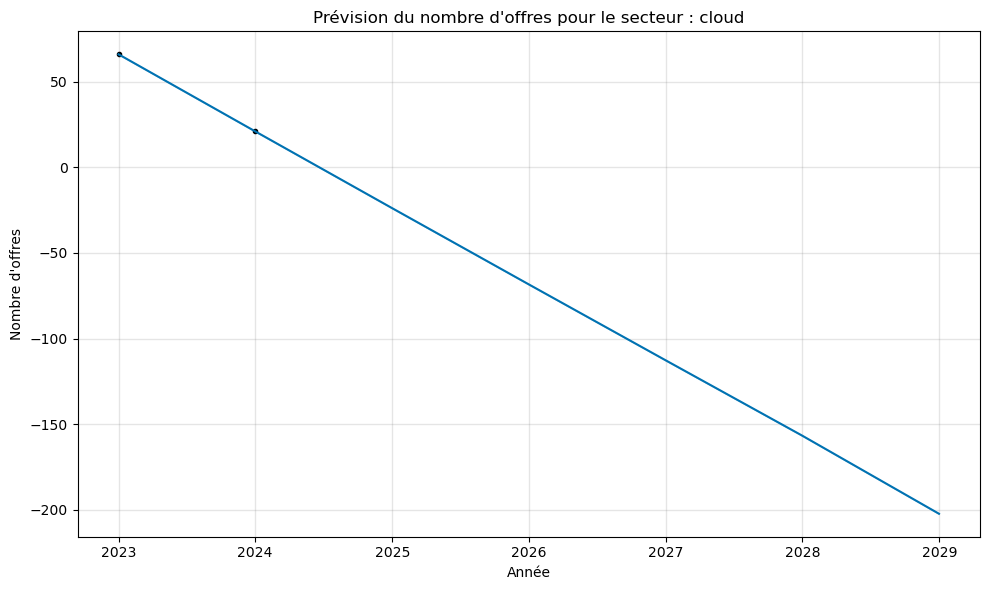

00:45:08 - cmdstanpy - INFO - Chain [1] start processing



Prévision pour le secteur : data


00:45:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18004\2564572686.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


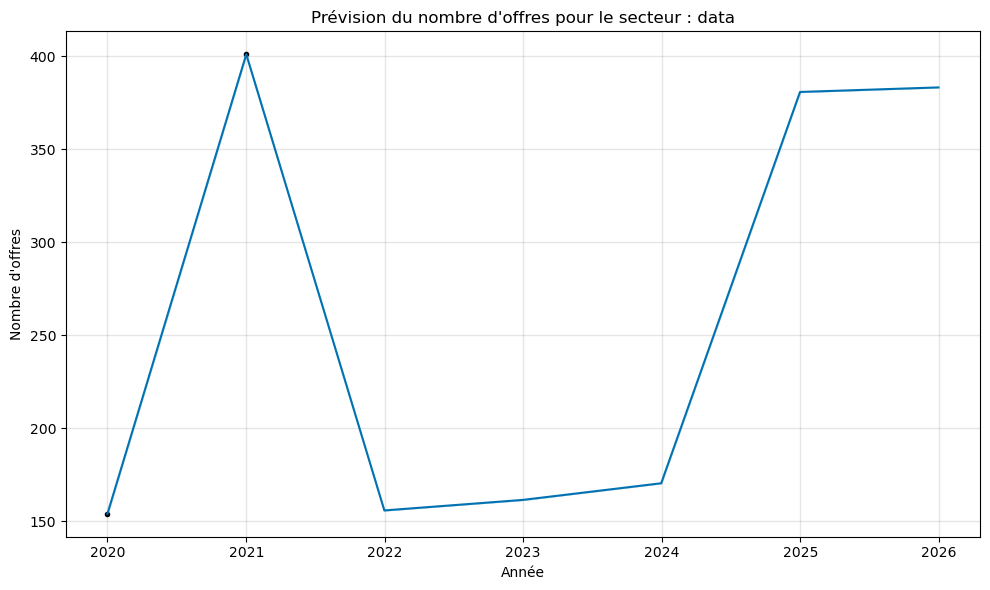


Prévision pour le secteur : informatique
Pas assez de données pour le secteur informatique.


In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Liste unique des secteurs
secteurs = df_grouped["Secteur"].unique()

for secteur in secteurs:
    print(f"\nPrévision pour le secteur : {secteur}")
    
    # Filtrer les données du secteur courant
    df_secteur = df_grouped[df_grouped["Secteur"] == secteur][["ds", "y"]].copy()
    
    # Skip s'il y a trop peu de données
    if len(df_secteur) < 2:
        print(f"Pas assez de données pour le secteur {secteur}.")
        continue
    
    # Initialiser et entraîner Prophet
    model = Prophet(yearly_seasonality=True)
    model.fit(df_secteur)
    
    # Générer les années futures (5 ans)
    future = model.make_future_dataframe(periods=5, freq="Y")
    
    # Prédictions
    forecast = model.predict(future)
    
    # Affichage du graphe
    fig = model.plot(forecast)
    plt.title(f"Prévision du nombre d'offres pour le secteur : {secteur}")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'offres")
    plt.tight_layout()
    plt.show()


In [11]:
# Après les prédictions pour l'objectif 1
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Fusion des données employabilité + offre
df = pd.merge(df_emploiyabilite, df_offre, left_on="fk_offre", right_on="pk_offre", how="inner")

# Regroupement : Nombre d'offres par secteur et année
df_grouped = df.groupby(["Secteur", "date_offre"]).size().reset_index(name="y")

# Création de la colonne 'ds' (Prophet demande une date)
df_grouped["ds"] = pd.to_datetime(df_grouped["date_offre"].astype(str) + "-01-01")

# Liste unique des secteurs
secteurs = df_grouped["Secteur"].unique()

# Initialiser une liste pour stocker les résultats
resultats_all_secteurs = []

for secteur in secteurs:
    print(f"\nPrévision pour le secteur : {secteur}")
    
    # Filtrer les données du secteur courant
    df_secteur = df_grouped[df_grouped["Secteur"] == secteur][["ds", "y"]].copy()
    
    # Skip s'il y a trop peu de données
    if len(df_secteur) < 2:
        print(f"Pas assez de données pour le secteur {secteur}.")
        continue
    
    # Initialiser et entraîner Prophet
    model = Prophet(yearly_seasonality=True)
    model.fit(df_secteur)
    
    # Générer les années futures (5 ans)
    future = model.make_future_dataframe(periods=5, freq="Y")
    
    # Prédictions
    forecast = model.predict(future)
    
    # Créer DataFrame pour les données historiques
    df_historique = df_secteur[["ds", "y"]].copy()
    df_historique["Secteur"] = secteur
    df_historique["Type"] = "Historique"
    df_historique.rename(columns={"y": "Nombre_Offres"}, inplace=True)
    
    # Créer DataFrame pour les prévisions
    df_predictions = forecast[["ds", "yhat"]].copy()
    df_predictions["secteur"] = secteur
    df_predictions["Type"] = "Prévision"
    df_predictions.rename(columns={"yhat": "Nombre_Offres"}, inplace=True)
    
    # Concaténer historique et prévisions
    df_resultats_secteur = pd.concat([df_historique, df_predictions], ignore_index=True)
    
    # Ajouter à la liste globale
    resultats_all_secteurs.append(df_resultats_secteur)

# Combiner tous les secteurs en un seul DataFrame
df_resultats_objectif1 = pd.concat(resultats_all_secteurs, ignore_index=True)

# Sauvegarder dans PostgreSQL
df_resultats_objectif1.to_sql("Resultats_Objectif1", engine, if_exists="replace", index=False)
print("✅ Résultats de l'Objectif 1 sauvegardés dans la table 'Resultats_Objectif1'")

# Optionnel : Sauvegarder en CSV
df_resultats_objectif1.to_csv("resultats_objectif1.csv", index=False)
print("✅ Résultats de l'Objectif 1 sauvegardés dans 'resultats_objectif1.csv'")

01:07:20 - cmdstanpy - INFO - Chain [1] start processing



Prévision pour le secteur : cloud


01:07:20 - cmdstanpy - INFO - Chain [1] done processing
01:07:21 - cmdstanpy - INFO - Chain [1] start processing



Prévision pour le secteur : data


01:07:21 - cmdstanpy - INFO - Chain [1] done processing



Prévision pour le secteur : informatique
Pas assez de données pour le secteur informatique.
✅ Résultats de l'Objectif 1 sauvegardés dans la table 'Resultats_Objectif1'
✅ Résultats de l'Objectif 1 sauvegardés dans 'resultats_objectif1.csv'


# Prédire les compétences qui seront les plus demandées sur le marché du travail 

🔹 Cible
Étudier l’évolution des compétences demandées sur le marché du travail.
Identifier les compétences émergentes pour mieux orienter les formations et recrutements.

🔹 Modèle utilisé
Modèle de régression linéaire.
Objectif : prédire les compétences les plus demandées dans les années à venir.

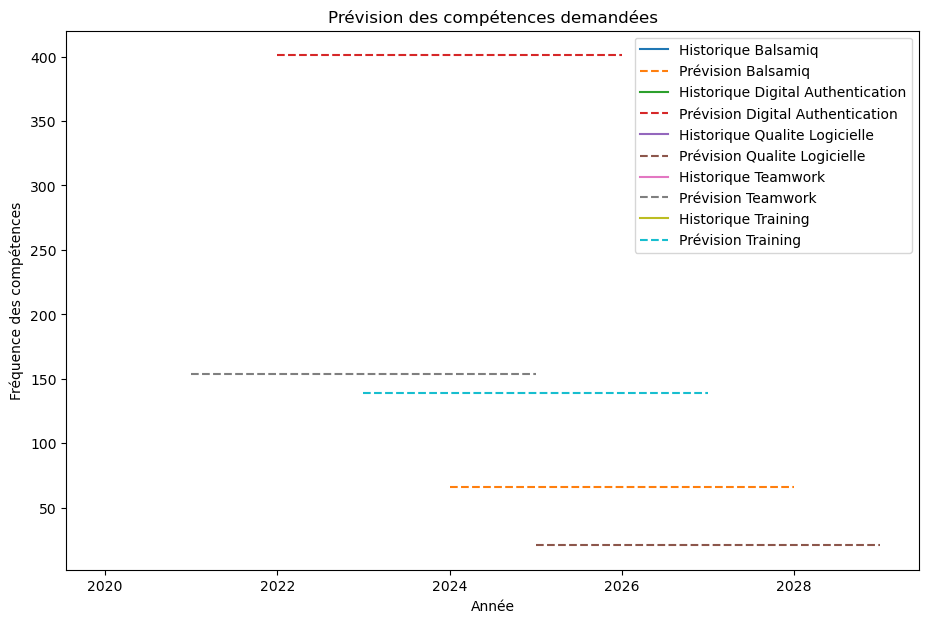

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Regrouper les compétences par année
df_comp = df.groupby(["Competence", "date_offre"]).size().reset_index(name="frequence")

# Liste des compétences à analyser
competences = df_comp["Competence"].unique()

# Créer une nouvelle figure avec une taille plus grande
plt.figure(figsize=(11, 7))  # Largeur=12, Hauteur=8 (tu peux ajuster selon ton besoin)
df_comp["date_offre"] = df_comp["date_offre"].astype(int)

for comp in competences:
    df_c = df_comp[df_comp["Competence"] == comp]
    
    # Appliquer une régression linéaire sur les fréquences par année
    X = df_c["date_offre"].values.reshape(-1, 1)  # Années
    y = df_c["frequence"].values  # Fréquence des compétences
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédire pour les années suivantes (ex: 5 années supplémentaires)
    future_years = np.array(range(df_c["date_offre"].max() + 1, df_c["date_offre"].max() + 6)).reshape(-1, 1)
    future_predictions = model.predict(future_years)
    
    # Tracer la courbe de la régression
    plt.plot(df_c["date_offre"], df_c["frequence"], label=f"Historique {comp}")
    plt.plot(future_years, future_predictions, label=f"Prévision {comp}", linestyle="--")

# Ajuster le titre et les labels
plt.title("Prévision des compétences demandées")
plt.xlabel("Année")
plt.ylabel("Fréquence des compétences")
plt.legend()

# Afficher le graphique
plt.show()


In [14]:
# Après les prédictions pour l'objectif 2
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Regrouper les compétences par année
df_comp = df.groupby(["Competence", "date_offre"]).size().reset_index(name="frequence")
df_comp["date_offre"] = df_comp["date_offre"].astype(int)

# Liste des compétences à analyser
competences = df_comp["Competence"].unique()

# Initialiser une liste pour stocker les résultats
resultats_all_competences = []

for comp in competences:
    df_c = df_comp[df_comp["Competence"] == comp]
    
    # Appliquer une régression linéaire sur les fréquences par année
    X = df_c["date_offre"].values.reshape(-1, 1)  # Années
    y = df_c["frequence"].values  # Fréquence des compétences
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédire pour les années suivantes (5 années supplémentaires)
    future_years = np.array(range(df_c["date_offre"].max() + 1, df_c["date_offre"].max() + 6)).reshape(-1, 1)
    future_predictions = model.predict(future_years)
    
    # Créer DataFrame pour les données historiques
    df_historique = df_c[["date_offre", "frequence"]].copy()
    df_historique["Competence"] = comp
    df_historique["Type"] = "Historique"
    df_historique.rename(columns={"date_offre": "Annee", "frequence": "Frequence_Competence"}, inplace=True)
    
    # Créer DataFrame pour les prévisions
    df_predictions = pd.DataFrame({
        "Annee": future_years.flatten(),
        "Frequence_Competence": future_predictions,
        "Competence": comp,
        "Type": "Prévision"
    })
    
    # Concaténer historique et prévisions
    df_resultats_comp = pd.concat([df_historique, df_predictions], ignore_index=True)
    
    # Ajouter à la liste globale
    resultats_all_competences.append(df_resultats_comp)

# Combiner toutes les compétences en un seul DataFrame
df_resultats_objectif2 = pd.concat(resultats_all_competences, ignore_index=True)

# Sauvegarder dans PostgreSQL
df_resultats_objectif2.to_sql("Resultats_Objectif2", engine, if_exists="replace", index=False)
print("✅ Résultats de l'Objectif 2 sauvegardés dans la table 'Resultats_Objectif2'")

# Optionnel : Sauvegarder en CSV
df_resultats_objectif2.to_csv("resultats_objectif2.csv", index=False)
print("✅ Résultats de l'Objectif 2 sauvegardés dans 'resultats_objectif2.csv'")

✅ Résultats de l'Objectif 2 sauvegardés dans la table 'Resultats_Objectif2'
✅ Résultats de l'Objectif 2 sauvegardés dans 'resultats_objectif2.csv'


# Prédire le temps moyen nécessaire à un diplômé pour décrocher un premier emploi.

🔹 Cible
Prédire le temps moyen nécessaire à un diplômé pour décrocher un premier emploi.
Aider les responsables à anticiper les délais d’insertion professionnelle et adapter les actions d’accompagnement.

🔹 Modèle utilisé
Modèle de prévision temporelle : ARIMA.
Objectif : prédire la durée moyenne sans emploi après diplomation sur les mois à venir

In [7]:
# Copie de la table employabilité
df_duree = df_emploiyabilite.copy()

# Nettoyage : remplacer les "N\A", "NA", etc. par NaT (Not a Time)
df_duree["date_diplome"] = pd.to_datetime(df_duree["date_diplome"], errors="coerce")
df_duree["position_date"] = pd.to_datetime(df_duree["position_date"], errors="coerce")

# Supprimer les lignes où l'une des deux dates est manquante
df_duree = df_duree.dropna(subset=["date_diplome", "position_date"])

# Calcul de la durée sans emploi en mois
df_duree["dureeSansTravail"] = (df_duree["position_date"] - df_duree["date_diplome"]).dt.days / 30

# Extraire le mois de diplomation
df_duree["moisDiplome"] = df_duree["date_diplome"].dt.to_period("M").dt.to_timestamp()

# Agrégation : durée moyenne par mois
df_ts = df_duree.groupby("moisDiplome")["dureeSansTravail"].mean().reset_index()
df_ts.rename(columns={"moisDiplome": "ds", "dureeSansTravail": "y"}, inplace=True)


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood o

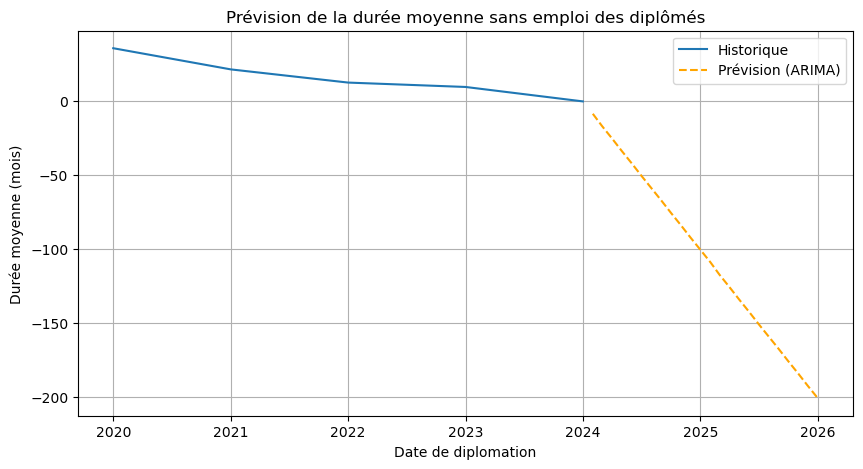

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# S'assurer que l'index est bien en datetime
df_ts.set_index("ds", inplace=True)

# Modélisation ARIMA (pas de composante saisonnière)
model = ARIMA(df_ts["y"], order=(1, 1, 1))
results = model.fit()

# Prédiction sur 24 mois
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_index = pd.date_range(start=df_ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq="MS")

# Affichage
plt.figure(figsize=(10, 5))
plt.plot(df_ts.index, df_ts["y"], label="Historique")
plt.plot(forecast_index, forecast_values, label="Prévision (ARIMA)", linestyle="--", color="orange")
plt.title("Prévision de la durée moyenne sans emploi des diplômés")
plt.xlabel("Date de diplomation")
plt.ylabel("Durée moyenne (mois)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Après les prédictions pour l'objectif 3
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Copie de la table employabilité
df_duree = df_emploiyabilite.copy()

# Nettoyage : remplacer les "N\A", "NA", etc. par NaT (Not a Time)
df_duree["date_diplome"] = pd.to_datetime(df_duree["date_diplome"], errors="coerce")
df_duree["position_date"] = pd.to_datetime(df_duree["position_date"], errors="coerce")

# Supprimer les lignes où l'une des deux dates est manquante
df_duree = df_duree.dropna(subset=["date_diplome", "position_date"])

# Calcul de la durée sans emploi en mois
df_duree["dureeSansTravail"] = (df_duree["position_date"] - df_duree["date_diplome"]).dt.days / 30

# Extraire le mois de diplomation
df_duree["moisDiplome"] = df_duree["date_diplome"].dt.to_period("M").dt.to_timestamp()

# Agrégation : durée moyenne par mois
df_ts = df_duree.groupby("moisDiplome")["dureeSansTravail"].mean().reset_index()
df_ts.rename(columns={"moisDiplome": "ds", "dureeSansTravail": "y"}, inplace=True)

# S'assurer que l'index est bien en datetime pour ARIMA
df_ts.set_index("ds", inplace=True)

# Modélisation ARIMA
model = ARIMA(df_ts["y"], order=(1, 1, 1))
results = model.fit()

# Prédiction sur 24 mois
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_index = pd.date_range(start=df_ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq="MS")

# Créer DataFrame pour les données historiques
df_historique = df_ts.reset_index()[["ds", "y"]].copy()
df_historique["Type"] = "Historique"
df_historique.rename(columns={"y": "Duree_Moyenne_Mois"}, inplace=True)

# Créer DataFrame pour les prévisions
df_predictions = pd.DataFrame({
    "ds": forecast_index,
    "Duree_Moyenne_Mois": forecast_values,
    "Type": "Prévision"
})

# Concaténer historique et prévisions
df_resultats_objectif3 = pd.concat([df_historique, df_predictions], ignore_index=True)

# Sauvegarder dans PostgreSQL
df_resultats_objectif3.to_sql("Resultats_Objectif3", engine, if_exists="replace", index=False)
print("✅ Résultats de l'Objectif 3 sauvegardés dans la table 'Resultats_Objectif3'")

# Optionnel : Sauvegarder en CSV
df_resultats_objectif3.to_csv("resultats_objectif3.csv", index=False)
print("✅ Résultats de l'Objectif 3 sauvegardés dans 'resultats_objectif3.csv'")

✅ Résultats de l'Objectif 3 sauvegardés dans la table 'Resultats_Objectif3'
✅ Résultats de l'Objectif 3 sauvegardés dans 'resultats_objectif3.csv'


C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood o